In [1]:
import torch
import os
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models.resnet import ResNet152_Weights
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset


In [2]:
def main(image_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    data_dir = 'dataset'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    print(dataset_sizes)

    class_names = image_datasets['train'].classes

    # Define the data augmentation transformations
    data_augmentation_transforms = transforms.Compose([
        transforms.RandomRotation(180),  # Rotate the image randomly by up to 180 degrees
        transforms.RandomHorizontalFlip(),  # Flip the image horizontally randomly
        transforms.RandomVerticalFlip(),  # Flip the image vertically randomly
        transforms.RandomResizedCrop(224),  # Crop a random portion of the image and resize it to 224x224
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust the image color randomly
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ])

    # Apply data augmentation to the existing dataset and create new dataloaders
    augmented_dataloaders = {x: torch.utils.data.DataLoader(
        ConcatDataset([image_datasets[x]] + [datasets.ImageFolder(os.path.join(data_dir, x), data_augmentation_transforms) for _ in range(9)]),
        batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Update the dataset sizes
    augmented_dataset_sizes = {x: len(augmented_dataloaders[x].dataset) for x in ['train', 'val']}

    # Print the updated dataset sizes
    print(augmented_dataset_sizes)
    class_names

    # Load the pre-trained ResNet-152 model
    model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

    # Freeze all layers except the final classification layer
    for name, param in model.named_parameters():
        if "fc" in name:  # Unfreeze the final classification layer
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.8)  # Use all parameters

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


    # Move the model to the GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_model_choice = input("apakah ingin melakukan training model baru? (y/n)")
    if train_model_choice.lower() == 'y':
        print("Melakukan training model..")
        # Training loop
        num_epochs = int(input("Enter the number of epochs: "))
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Start the timer
                start_time = time.time()

                for inputs, labels in augmented_dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / augmented_dataset_sizes[phase]
                epoch_acc = running_corrects.double() / augmented_dataset_sizes[phase]

                # End the timer and calculate the elapsed time
                end_time = time.time()
                elapsed_time = end_time - start_time

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, Time: {elapsed_time:.2f} seconds')

                # Step the scheduler
                if phase == 'train':
                    scheduler.step()

        print("Training complete!")

        # Save the model
        torch.save(model.state_dict(), 'chiliHealth_classification_model_copy_clb.pth')
    else: 
        print("Menggunakan model yang sudah ada")

    # Load the saved model
    model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 1000)  # Match the output units of the saved model
    model.load_state_dict(torch.load('chiliHealth_classification_model_copy_clb.pth'))
    model.eval()

    # Create a new model with the correct final layer
    new_model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
    new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

    # Copy the weights and biases from the loaded model to the new model
    new_model.fc.weight.data = model.fc.weight.data[0:2].clone()  # Copy only the first 2 output units
    new_model.fc.bias.data = model.fc.bias.data[0:2].clone()

    # Load and preprocess the unseen image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = output.max(1)

    # Map the predicted class to the class name
    class_names = ['Healthy', 'notHealthy']  # Make sure these class names match training data
    predicted_class_name = class_names[predicted_class.item()]

    print(f'The predicted class is: {predicted_class_name}')

    # Display the image with the predicted class name
    image = np.array(image)
    plt.imshow(image)
    plt.axis('off')
    plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='black', backgroundcolor='red' if predicted_class.item() == 1 else 'green')
    plt.show()

{'train': 573, 'val': 155}
{'train': 5730, 'val': 1550}
Menggunakan model yang sudah ada
The predicted class is: notHealthy


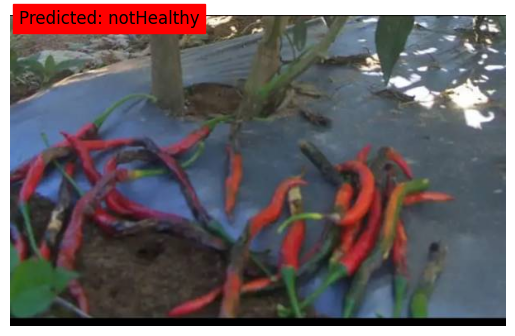

In [3]:
# Call the main function with the image_path parameter
main('testGambarTS.jpeg')